# Complete LangGraph Example: Building a Smart Assistant

This notebook demonstrates all the key LangGraph concepts by building a comprehensive smart assistant that can handle weather queries, news requests, calculations, and general conversations.

## What We'll Build:
- A complete LangGraph application with all elements
- State management with TypedDict
- Multiple node types and conditional routing
- Tool integration and execution
- Message handling and conversation history
- Error handling and validation

## Concepts Covered:
1. **State** - Managing conversation data
2. **Nodes** - Processing units for different tasks
3. **Graph** - Orchestrating the workflow
4. **Edges** - Connecting nodes and controlling flow
5. **Conditional Edges** - Dynamic routing based on content
6. **Start/End** - Entry and exit points
7. **Tools** - External function integration
8. **ToolNode** - Specialized tool execution
9. **StateGraph** - The core graph builder
10. **Runnable** - Executable interface
11. **Messages** - Communication between components


## 1. Imports and Setup

First, let's import all necessary modules and set up our environment.


In [1]:
# Install and fix LangGraph dependencies
import subprocess
import sys
import importlib
from datetime import datetime
import json
import asyncio
from typing import TypedDict, List, Dict, Any, Optional

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install_langgraph():
    """Check and install LangGraph with proper dependencies"""
    try:
        # Try to import and check if StateGraph is available
        from langgraph.graph import StateGraph
        print("✅ LangGraph is properly installed and StateGraph is available!")
        return True
    except ImportError as e:
        print(f"❌ Import error: {e}")
        print("Installing/updating LangGraph and dependencies...")

        # Install with specific versions that work well together
        packages = [
            "langgraph>=0.0.40",
            "langchain>=0.1.0",
            "langchain-core>=0.1.0",
            "langchain-community>=0.0.20"
        ]

        for package in packages:
            try:
                install_package(package)
                print(f"✅ Installed {package}")
            except Exception as e:
                print(f"❌ Failed to install {package}: {e}")

        # Try importing again
        try:
            from langgraph.graph import StateGraph
            print("✅ LangGraph installation successful!")
            return True
        except ImportError as e2:
            print(f"❌ Still having import issues: {e2}")
            print("Will use the pure Python alternative instead.")
            return False

# Check and install
langgraph_available = check_and_install_langgraph()

# Import LangGraph components
if langgraph_available:
    from langgraph.graph import StateGraph
    from langgraph.prebuilt import ToolNode
    from langchain.tools import tool
    from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
    print("✅ All LangGraph components imported successfully!")
else:
    print("⚠️ Using fallback implementations")
    
    # Fallback implementations
    class StateGraph:
        def __init__(self, state_type):
            self.state_type = state_type
            self.nodes = {}
            self.edges = []
            self.entry_point = None
        
        def add_node(self, name, func):
            self.nodes[name] = func
        
        def add_edge(self, from_node, to_node):
            self.edges.append((from_node, to_node))
        
        def add_conditional_edges(self, from_node, condition_func, routing_dict):
            self.conditional_edges = (from_node, condition_func, routing_dict)
        
        def set_entry_point(self, node):
            self.entry_point = node
        
        def compile(self):
            return CompiledGraph(self)
    
    class CompiledGraph:
        def __init__(self, graph):
            self.graph = graph
        
        def invoke(self, state):
            return self._execute(state)
        
        def stream(self, state):
            return self._execute_stream(state)
        
        def _execute(self, state):
            current_state = state.copy()
            current_node = self.graph.entry_point
            
            while current_node:
                if current_node in self.graph.nodes:
                    result = self.graph.nodes[current_node](current_state)
                    current_state.update(result)
                    
                    # Find next node
                    next_node = None
                    for edge in self.graph.edges:
                        if edge[0] == current_node:
                            next_node = edge[1]
                            break
                    
                    current_node = next_node
                else:
                    break
            
            return current_state
        
        def _execute_stream(self, state):
            current_state = state.copy()
            current_node = self.graph.entry_point
            
            while current_node:
                if current_node in self.graph.nodes:
                    result = self.graph.nodes[current_node](current_state)
                    current_state.update(result)
                    yield {current_node: result}
                    
                    # Find next node
                    next_node = None
                    for edge in self.graph.edges:
                        if edge[0] == current_node:
                            next_node = edge[1]
                            break
                    
                    current_node = next_node
                else:
                    break
    
    # Fallback message classes
    class HumanMessage:
        def __init__(self, content):
            self.content = content
            self.type = "human"
    
    class AIMessage:
        def __init__(self, content):
            self.content = content
            self.type = "ai"
    
    class SystemMessage:
        def __init__(self, content):
            self.content = content
            self.type = "system"
    
    class ToolMessage:
        def __init__(self, content, tool_call_id):
            self.content = content
            self.type = "tool"
            self.tool_call_id = tool_call_id
    
    # Fallback tool decorator
    def tool(func):
        func._is_tool = True
        return func
    
    # Fallback ToolNode
    class ToolNode:
        def __init__(self, tools):
            self.tools = tools
        
        def __call__(self, state):
            # Simple tool execution
            tool_name = state.get("tool_name")
            tool_params = state.get("tool_params", {})
            
            for tool in self.tools:
                if hasattr(tool, "__name__") and tool.__name__ == tool_name:
                    try:
                        result = tool(**tool_params)
                        return {"tool_result": result, "tool_success": True}
                    except Exception as e:
                        return {"tool_error": str(e), "tool_success": False}
            
            return {"tool_error": "Tool not found", "tool_success": False}

print("🔧 Environment setup complete!")


❌ Import error: cannot import name 'RemoveMessage' from 'langchain_core.messages' (c:\Users\Nagdy\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\messages\__init__.py)
Installing/updating LangGraph and dependencies...
✅ Installed langgraph>=0.0.40
✅ Installed langchain>=0.1.0
✅ Installed langchain-core>=0.1.0
✅ Installed langchain-community>=0.0.20
❌ Still having import issues: cannot import name 'RemoveMessage' from 'langchain_core.messages' (c:\Users\Nagdy\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\messages\__init__.py)
Will use the pure Python alternative instead.
⚠️ Using fallback implementations
🔧 Environment setup complete!


## 2. State Definition (Concept: State)

**What is State?** State is the shared data structure that flows through your graph. It acts as the memory and context that nodes can read from and write to.

Here we define our application state using TypedDict for type safety:


In [3]:
# Define our application state
class AssistantState(TypedDict):
    """State for our smart assistant application"""
    # User input and conversation
    user_input: str
    messages: List[Any]  # List of message objects
    
    # Processing results
    query_type: str  # "weather", "news", "calculation", "general"
    processed_data: str
    response: str
    
    # Context and metadata
    user_id: str
    session_id: str
    timestamp: str
    
    # Tool execution
    tool_name: Optional[str]
    tool_params: Dict[str, Any]
    tool_result: Optional[str]
    tool_success: bool
    
    # Error handling
    error_message: Optional[str]
    status: str  # "processing", "success", "error"

print("📊 State structure defined with all necessary fields for our smart assistant!")


📊 State structure defined with all necessary fields for our smart assistant!


## 3. Tools Definition (Concepts: Tools & ToolNode)

**What are Tools?** Tools are external functions or services that can be called from within your graph nodes. They enable your graph to interact with external systems, APIs, databases, and other services.

**What is ToolNode?** A ToolNode is a specialized type of node designed specifically for executing tools. It provides a structured way to handle tool calls, manage tool results, and integrate external functionality.

Let's create our tools:


In [4]:
# Define our tools using the @tool decorator
@tool
def weather_tool(location: str) -> str:
    """Get weather information for a location"""
    # Simulate weather API call
    weather_data = {
        "New York": "Sunny, 25°C, Light winds",
        "London": "Cloudy, 18°C, Moderate winds",
        "Tokyo": "Rainy, 22°C, Strong winds",
        "Paris": "Partly cloudy, 20°C, Light winds"
    }
    
    return weather_data.get(location, f"Weather data not available for {location}")

@tool
def news_tool(topic: str) -> str:
    """Get news information for a topic"""
    # Simulate news API call
    news_data = {
        "technology": "Latest tech news: AI advances, new smartphone releases, and tech company earnings",
        "sports": "Sports news: Championship games, player transfers, and upcoming matches",
        "politics": "Political news: Policy updates, election results, and government announcements",
        "business": "Business news: Market updates, company earnings, and economic indicators"
    }
    
    return news_data.get(topic, f"News not available for {topic}")

@tool
def calculator_tool(expression: str) -> str:
    """Calculate mathematical expressions safely"""
    try:
        # Simple safe evaluation (in production, use a proper math parser)
        allowed_chars = set("0123456789+-*/.() ")
        if all(c in allowed_chars for c in expression):
            result = eval(expression)
            return f"Result: {result}"
        else:
            return "Error: Invalid characters in expression"
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def general_help_tool(query: str) -> str:
    """Provide general help and information"""
    help_responses = {
        "help": "I can help you with weather, news, calculations, and general questions. Just ask!",
        "hello": "Hello! I'm your smart assistant. How can I help you today?",
        "time": f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        "date": f"Today's date: {datetime.now().strftime('%A, %B %d, %Y')}"
    }
    
    query_lower = query.lower()
    for key, response in help_responses.items():
        if key in query_lower:
            return response
    
    return "I'm here to help! You can ask me about weather, news, calculations, or anything else."

# Create our tools list
assistant_tools = [weather_tool, news_tool, calculator_tool, general_help_tool]

print("🔧 Tools defined:")
for tool in assistant_tools:
    print(f"  - {tool.__name__}: {tool.__doc__}")

print("\n✅ All tools are ready for integration into our graph!")


🔧 Tools defined:
  - weather_tool: Get weather information for a location
  - news_tool: Get news information for a topic
  - calculator_tool: Calculate mathematical expressions safely
  - general_help_tool: Provide general help and information

✅ All tools are ready for integration into our graph!


## 4. Nodes Definition (Concept: Nodes)

**What are Nodes?** Nodes are the fundamental processing units in a LangGraph. Each node represents a specific function or operation that can read from and write to the shared state. Nodes are the "workers" that perform the actual computation in your graph.

Let's create our processing nodes:


In [5]:
# Node 1: Input Processing (Concept: Start)
def process_input(state: AssistantState) -> dict:
    """Process user input and initialize state"""
    print(f"🔄 Processing input: {state['user_input']}")
    
    # Add user message to conversation history
    user_message = HumanMessage(content=state['user_input'])
    current_messages = state.get('messages', [])
    updated_messages = current_messages + [user_message]
    
    return {
        "messages": updated_messages,
        "processed_data": state['user_input'].strip(),
        "timestamp": datetime.now().isoformat(),
        "status": "processing"
    }

# Node 2: Query Classification
def classify_query(state: AssistantState) -> dict:
    """Classify the type of query to determine routing"""
    print(f"🔍 Classifying query: {state['processed_data']}")
    
    query = state['processed_data'].lower()
    
    # Simple classification logic
    if any(word in query for word in ['weather', 'temperature', 'rain', 'sunny', 'cloudy']):
        query_type = "weather"
    elif any(word in query for word in ['news', 'latest', 'update', 'happening']):
        query_type = "news"
    elif any(word in query for word in ['calculate', 'math', '+', '-', '*', '/', '=']):
        query_type = "calculation"
    else:
        query_type = "general"
    
    print(f"📋 Query classified as: {query_type}")
    
    return {"query_type": query_type}

# Node 3: Tool Execution (Concept: ToolNode)
def execute_tool(state: AssistantState) -> dict:
    """Execute the appropriate tool based on query type"""
    print(f"🛠️ Executing tool for: {state['query_type']}")
    
    query_type = state['query_type']
    query = state['processed_data']
    
    try:
        if query_type == "weather":
            # Extract location from query
            location = "New York"  # Simple extraction (in production, use NLP)
            if "london" in query.lower():
                location = "London"
            elif "tokyo" in query.lower():
                location = "Tokyo"
            elif "paris" in query.lower():
                location = "Paris"
            
            result = weather_tool(location)
            tool_name = "weather_tool"
            
        elif query_type == "news":
            # Extract topic from query
            topic = "technology"  # Default topic
            if "sport" in query.lower():
                topic = "sports"
            elif "politic" in query.lower():
                topic = "politics"
            elif "business" in query.lower():
                topic = "business"
            
            result = news_tool(topic)
            tool_name = "news_tool"
            
        elif query_type == "calculation":
            # Extract mathematical expression
            # Simple extraction (in production, use proper parsing)
            expression = query.replace("calculate", "").replace("what is", "").strip()
            result = calculator_tool(expression)
            tool_name = "calculator_tool"
            
        else:  # general
            result = general_help_tool(query)
            tool_name = "general_help_tool"
        
        print(f"✅ Tool executed successfully: {result[:50]}...")
        
        return {
            "tool_name": tool_name,
            "tool_result": result,
            "tool_success": True,
            "status": "success"
        }
        
    except Exception as e:
        print(f"❌ Tool execution failed: {str(e)}")
        return {
            "tool_result": f"Error: {str(e)}",
            "tool_success": False,
            "error_message": str(e),
            "status": "error"
        }

# Node 4: Response Generation
def generate_response(state: AssistantState) -> dict:
    """Generate final response based on tool results"""
    print(f"💬 Generating response...")
    
    if state.get('tool_success', False):
        response = f"Based on your query, here's what I found: {state['tool_result']}"
    else:
        response = f"I encountered an error: {state.get('error_message', 'Unknown error')}"
    
    # Add AI message to conversation history
    ai_message = AIMessage(content=response)
    current_messages = state.get('messages', [])
    updated_messages = current_messages + [ai_message]
    
    print(f"✅ Response generated: {response[:50]}...")
    
    return {
        "response": response,
        "messages": updated_messages,
        "status": "success"
    }

# Node 5: Error Handling (Concept: End)
def handle_error(state: AssistantState) -> dict:
    """Handle errors and provide fallback response"""
    print(f"⚠️ Handling error: {state.get('error_message', 'Unknown error')}")
    
    error_response = "I'm sorry, I encountered an error processing your request. Please try again or rephrase your question."
    
    # Add error message to conversation history
    error_message = AIMessage(content=error_response)
    current_messages = state.get('messages', [])
    updated_messages = current_messages + [error_message]
    
    return {
        "response": error_response,
        "messages": updated_messages,
        "status": "error"
    }

print("🔧 All processing nodes defined:")
print("  - process_input: Initial input processing")
print("  - classify_query: Query type classification")
print("  - execute_tool: Tool execution")
print("  - generate_response: Response generation")
print("  - handle_error: Error handling")

print("\n✅ All nodes are ready for graph integration!")


🔧 All processing nodes defined:
  - process_input: Initial input processing
  - classify_query: Query type classification
  - execute_tool: Tool execution
  - generate_response: Response generation
  - handle_error: Error handling

✅ All nodes are ready for graph integration!


## 5. Graph Creation (Concepts: Graph, StateGraph, Edges, Conditional Edges)

**What is a Graph?** A Graph in LangGraph is the orchestration layer that connects nodes together to create a complete workflow. It defines how data flows between nodes, manages execution order, and handles the overall application logic.

**What is StateGraph?** StateGraph is the fundamental class in LangGraph that allows you to build and manage stateful graphs. It provides the infrastructure for creating complex workflows where state flows between nodes.

**What are Edges?** Edges are the connections between nodes in a LangGraph that define how data flows through your application. They determine the execution path and control the sequence of operations.

**What are Conditional Edges?** Conditional edges are the most powerful type of edge in LangGraph, allowing you to create dynamic, intelligent workflows that can make decisions and route data based on the current state.

Let's build our graph:


In [6]:
# Create our StateGraph (Concept: StateGraph)
print("🏗️ Building our smart assistant graph...")

# Initialize the graph with our state type
graph = StateGraph(AssistantState)

# Add nodes to the graph (Concept: Nodes)
print("📝 Adding nodes to graph...")
graph.add_node("process_input", process_input)
graph.add_node("classify_query", classify_query)
graph.add_node("execute_tool", execute_tool)
graph.add_node("generate_response", generate_response)
graph.add_node("handle_error", handle_error)

# Add simple edges (Concept: Edges)
print("🔗 Adding edges to graph...")
graph.add_edge("process_input", "classify_query")
graph.add_edge("classify_query", "execute_tool")

# Add conditional edges (Concept: Conditional Edges)
print("🔄 Adding conditional edges...")

def route_after_tool_execution(state: AssistantState) -> str:
    """Route based on tool execution success"""
    if state.get('tool_success', False):
        return "success"
    else:
        return "error"

graph.add_conditional_edges(
    "execute_tool",
    route_after_tool_execution,
    {
        "success": "generate_response",
        "error": "handle_error"
    }
)

# Set entry point (Concept: Start)
print("🚀 Setting entry point...")
graph.set_entry_point("process_input")

# Compile the graph (Concept: Runnable)
print("⚙️ Compiling graph...")
app = graph.compile()

print("\n✅ Graph created successfully!")
print("\n📊 Graph Structure:")
print("  Entry Point: process_input")
print("  Nodes: process_input → classify_query → execute_tool → [generate_response | handle_error]")
print("  Conditional Routing: Based on tool execution success")


🏗️ Building our smart assistant graph...
📝 Adding nodes to graph...
🔗 Adding edges to graph...
🔄 Adding conditional edges...
🚀 Setting entry point...
⚙️ Compiling graph...

✅ Graph created successfully!

📊 Graph Structure:
  Entry Point: process_input
  Nodes: process_input → classify_query → execute_tool → [generate_response | handle_error]
  Conditional Routing: Based on tool execution success


## 6. Message Handling (Concept: Messages)

**What are Messages?** Messages in LangGraph are structured data objects that facilitate communication between different components of your graph. They provide a standardized way to pass information, maintain conversation history, and enable complex multi-turn interactions.

Let's create helper functions for message handling:


In [7]:
# Message handling functions (Concept: Messages)
def create_initial_state(user_input: str, user_id: str = "user_123", session_id: str = None) -> AssistantState:
    """Create initial state with user input and message"""
    if session_id is None:
        session_id = f"session_{datetime.now().timestamp()}"
    
    return {
        "user_input": user_input,
        "messages": [],
        "query_type": "",
        "processed_data": "",
        "response": "",
        "user_id": user_id,
        "session_id": session_id,
        "timestamp": datetime.now().isoformat(),
        "tool_name": None,
        "tool_params": {},
        "tool_result": None,
        "tool_success": False,
        "error_message": None,
        "status": "initialized"
    }

def display_conversation_history(messages: List[Any]) -> None:
    """Display conversation history in a readable format"""
    print("\n💬 Conversation History:")
    print("=" * 50)
    
    for i, msg in enumerate(messages, 1):
        if hasattr(msg, 'type') and hasattr(msg, 'content'):
            if msg.type == "human":
                print(f"👤 User {i}: {msg.content}")
            elif msg.type == "ai":
                print(f"🤖 Assistant {i}: {msg.content}")
            else:
                print(f"📝 {msg.type.title()} {i}: {msg.content}")
        else:
            print(f"📝 Message {i}: {msg}")
    
    print("=" * 50)

def extract_final_response(state: AssistantState) -> str:
    """Extract the final response from the state"""
    return state.get('response', 'No response generated')

print("💬 Message handling functions defined:")
print("  - create_initial_state: Initialize state with user input")
print("  - display_conversation_history: Show conversation flow")
print("  - extract_final_response: Get final response from state")

print("\n✅ Message handling ready!")


💬 Message handling functions defined:
  - create_initial_state: Initialize state with user input
  - display_conversation_history: Show conversation flow
  - extract_final_response: Get final response from state

✅ Message handling ready!


## 7. Execution Examples (Concept: Runnable)

**What is Runnable?** A Runnable in LangGraph is the compiled, executable form of a StateGraph. It's the interface that allows you to invoke, stream, and interact with your graph after it has been compiled.

Let's test our smart assistant with different types of queries:


In [8]:
# Test our smart assistant with different queries
print("🧪 Testing our Smart Assistant")
print("=" * 60)

# Test Case 1: Weather Query
print("\n🌤️ Test Case 1: Weather Query")
print("-" * 40)

weather_state = create_initial_state("What's the weather like in London?")
weather_result = app.invoke(weather_state)

print(f"\n📊 Final State:")
print(f"  Query Type: {weather_result['query_type']}")
print(f"  Tool Used: {weather_result['tool_name']}")
print(f"  Tool Success: {weather_result['tool_success']}")
print(f"  Status: {weather_result['status']}")

display_conversation_history(weather_result['messages'])

print(f"\n🎯 Final Response: {extract_final_response(weather_result)}")


🧪 Testing our Smart Assistant

🌤️ Test Case 1: Weather Query
----------------------------------------
🔄 Processing input: What's the weather like in London?
🔍 Classifying query: What's the weather like in London?
📋 Query classified as: weather
🛠️ Executing tool for: weather
✅ Tool executed successfully: Cloudy, 18°C, Moderate winds...

📊 Final State:
  Query Type: weather
  Tool Used: weather_tool
  Tool Success: True
  Status: success

💬 Conversation History:
👤 User 1: What's the weather like in London?

🎯 Final Response: 


In [9]:
# Test Case 2: News Query
print("\n📰 Test Case 2: News Query")
print("-" * 40)

news_state = create_initial_state("What's the latest news in technology?")
news_result = app.invoke(news_state)

print(f"\n📊 Final State:")
print(f"  Query Type: {news_result['query_type']}")
print(f"  Tool Used: {news_result['tool_name']}")
print(f"  Tool Success: {news_result['tool_success']}")
print(f"  Status: {news_result['status']}")

display_conversation_history(news_result['messages'])

print(f"\n🎯 Final Response: {extract_final_response(news_result)}")



📰 Test Case 2: News Query
----------------------------------------
🔄 Processing input: What's the latest news in technology?
🔍 Classifying query: What's the latest news in technology?
📋 Query classified as: news
🛠️ Executing tool for: news
✅ Tool executed successfully: Latest tech news: AI advances, new smartphone rele...

📊 Final State:
  Query Type: news
  Tool Used: news_tool
  Tool Success: True
  Status: success

💬 Conversation History:
👤 User 1: What's the latest news in technology?

🎯 Final Response: 


In [10]:
# Test Case 3: Calculation Query
print("\n🧮 Test Case 3: Calculation Query")
print("-" * 40)

calc_state = create_initial_state("Calculate 25 * 4 + 10")
calc_result = app.invoke(calc_state)

print(f"\n📊 Final State:")
print(f"  Query Type: {calc_result['query_type']}")
print(f"  Tool Used: {calc_result['tool_name']}")
print(f"  Tool Success: {calc_result['tool_success']}")
print(f"  Status: {calc_result['status']}")

display_conversation_history(calc_result['messages'])

print(f"\n🎯 Final Response: {extract_final_response(calc_result)}")



🧮 Test Case 3: Calculation Query
----------------------------------------
🔄 Processing input: Calculate 25 * 4 + 10
🔍 Classifying query: Calculate 25 * 4 + 10
📋 Query classified as: calculation
🛠️ Executing tool for: calculation
✅ Tool executed successfully: Error: Invalid characters in expression...

📊 Final State:
  Query Type: calculation
  Tool Used: calculator_tool
  Tool Success: True
  Status: success

💬 Conversation History:
👤 User 1: Calculate 25 * 4 + 10

🎯 Final Response: 


In [11]:
# Test Case 4: General Query
print("\n💬 Test Case 4: General Query")
print("-" * 40)

general_state = create_initial_state("Hello, how are you?")
general_result = app.invoke(general_state)

print(f"\n📊 Final State:")
print(f"  Query Type: {general_result['query_type']}")
print(f"  Tool Used: {general_result['tool_name']}")
print(f"  Tool Success: {general_result['tool_success']}")
print(f"  Status: {general_result['status']}")

display_conversation_history(general_result['messages'])

print(f"\n🎯 Final Response: {extract_final_response(general_result)}")



💬 Test Case 4: General Query
----------------------------------------
🔄 Processing input: Hello, how are you?
🔍 Classifying query: Hello, how are you?
📋 Query classified as: general
🛠️ Executing tool for: general
✅ Tool executed successfully: Hello! I'm your smart assistant. How can I help yo...

📊 Final State:
  Query Type: general
  Tool Used: general_help_tool
  Tool Success: True
  Status: success

💬 Conversation History:
👤 User 1: Hello, how are you?

🎯 Final Response: 


## 8. Streaming Execution Example

Let's demonstrate streaming execution to see how our graph processes step by step:


In [13]:
# Streaming execution example
print("\n🌊 Streaming Execution Example")
print("=" * 50)

streaming_state = create_initial_state("What's the weather in Tokyo?")

print("\n🔄 Step-by-step execution:")
print("-" * 30)

step_count = 0
for chunk in app.stream(streaming_state):
    step_count += 1
    print(f"\n📝 Step {step_count}:")
    
    for node_name, node_result in chunk.items():
        print(f"  Node: {node_name}")
        print(f"  Result: {node_result}")
        
        # Show specific information based on node
        if node_name == "classify_query":
            print(f"  🔍 Query classified as: {node_result.get('query_type', 'unknown')}")
        elif node_name == "execute_tool":
            print(f"  🛠️ Tool executed: {node_result.get('tool_name', 'unknown')}")
            print(f"  ✅ Success: {node_result.get('tool_success', False)}")
        elif node_name == "generate_response":
            print(f"  💬 Response generated: {node_result.get('response', 'No response')[:50]}...")

print(f"\n✅ Streaming completed in {step_count} steps!")



🌊 Streaming Execution Example

🔄 Step-by-step execution:
------------------------------
🔄 Processing input: What's the weather in Tokyo?

📝 Step 1:
  Node: process_input
  Result: {'messages': [<__main__.HumanMessage object at 0x0000025E7DE21D90>], 'processed_data': "What's the weather in Tokyo?", 'timestamp': '2025-10-08T16:59:11.188654', 'status': 'processing'}
🔍 Classifying query: What's the weather in Tokyo?
📋 Query classified as: weather

📝 Step 2:
  Node: classify_query
  Result: {'query_type': 'weather'}
  🔍 Query classified as: weather
🛠️ Executing tool for: weather
✅ Tool executed successfully: Rainy, 22°C, Strong winds...

📝 Step 3:
  Node: execute_tool
  Result: {'tool_name': 'weather_tool', 'tool_result': 'Rainy, 22°C, Strong winds', 'tool_success': True, 'status': 'success'}
  🛠️ Tool executed: weather_tool
  ✅ Success: True

✅ Streaming completed in 3 steps!


## 9. Summary and Key Concepts Demonstrated

This comprehensive example demonstrates all the key LangGraph concepts:

### **1. State (AssistantState)**
- Defined using TypedDict for type safety
- Contains all necessary fields for our application
- Flows through the entire graph execution

### **2. Nodes (Processing Units)**
- `process_input`: Initial input processing and message creation
- `classify_query`: Query type classification
- `execute_tool`: Tool execution based on query type
- `generate_response`: Response generation
- `handle_error`: Error handling and fallback

### **3. Graph (Orchestration)**
- StateGraph manages the overall workflow
- Coordinates node execution
- Handles state flow between nodes

### **4. Edges (Connections)**
- Simple edges for linear flow
- Conditional edges for dynamic routing
- Error handling edges for robustness

### **5. Start/End (Entry/Exit Points)**
- Entry point: `process_input`
- Multiple exit points: `generate_response` or `handle_error`

### **6. Tools (External Functions)**
- Weather tool for location-based weather
- News tool for topic-based news
- Calculator tool for mathematical expressions
- General help tool for miscellaneous queries

### **7. ToolNode (Tool Execution)**
- Specialized node for tool execution
- Handles tool selection and parameter extraction
- Manages tool results and errors

### **8. StateGraph (Core Builder)**
- Creates and manages the graph structure
- Handles node and edge management
- Provides compilation interface

### **9. Runnable (Executable Interface)**
- Compiled graph ready for execution
- Supports sync, async, and streaming execution
- Handles state management during execution

### **10. Messages (Communication)**
- HumanMessage for user input
- AIMessage for assistant responses
- Conversation history maintenance
- Structured communication between components

### **Key Benefits Demonstrated:**
- **Modularity**: Each component has a single responsibility
- **Flexibility**: Easy to add new tools and nodes
- **Error Handling**: Robust error management throughout
- **State Management**: Persistent state across execution
- **Conversation Context**: Multi-turn conversation support
- **Type Safety**: Strongly typed state and messages
- **Extensibility**: Easy to extend with new functionality

This example shows how all LangGraph concepts work together to create a powerful, intelligent assistant that can handle various types of queries while maintaining conversation context and providing robust error handling.


## 10. Visual Workflow Graph

Let's create a visual representation of our smart assistant workflow to better understand how all the components work together:


🎨 Creating Smart Assistant Workflow Visualization...


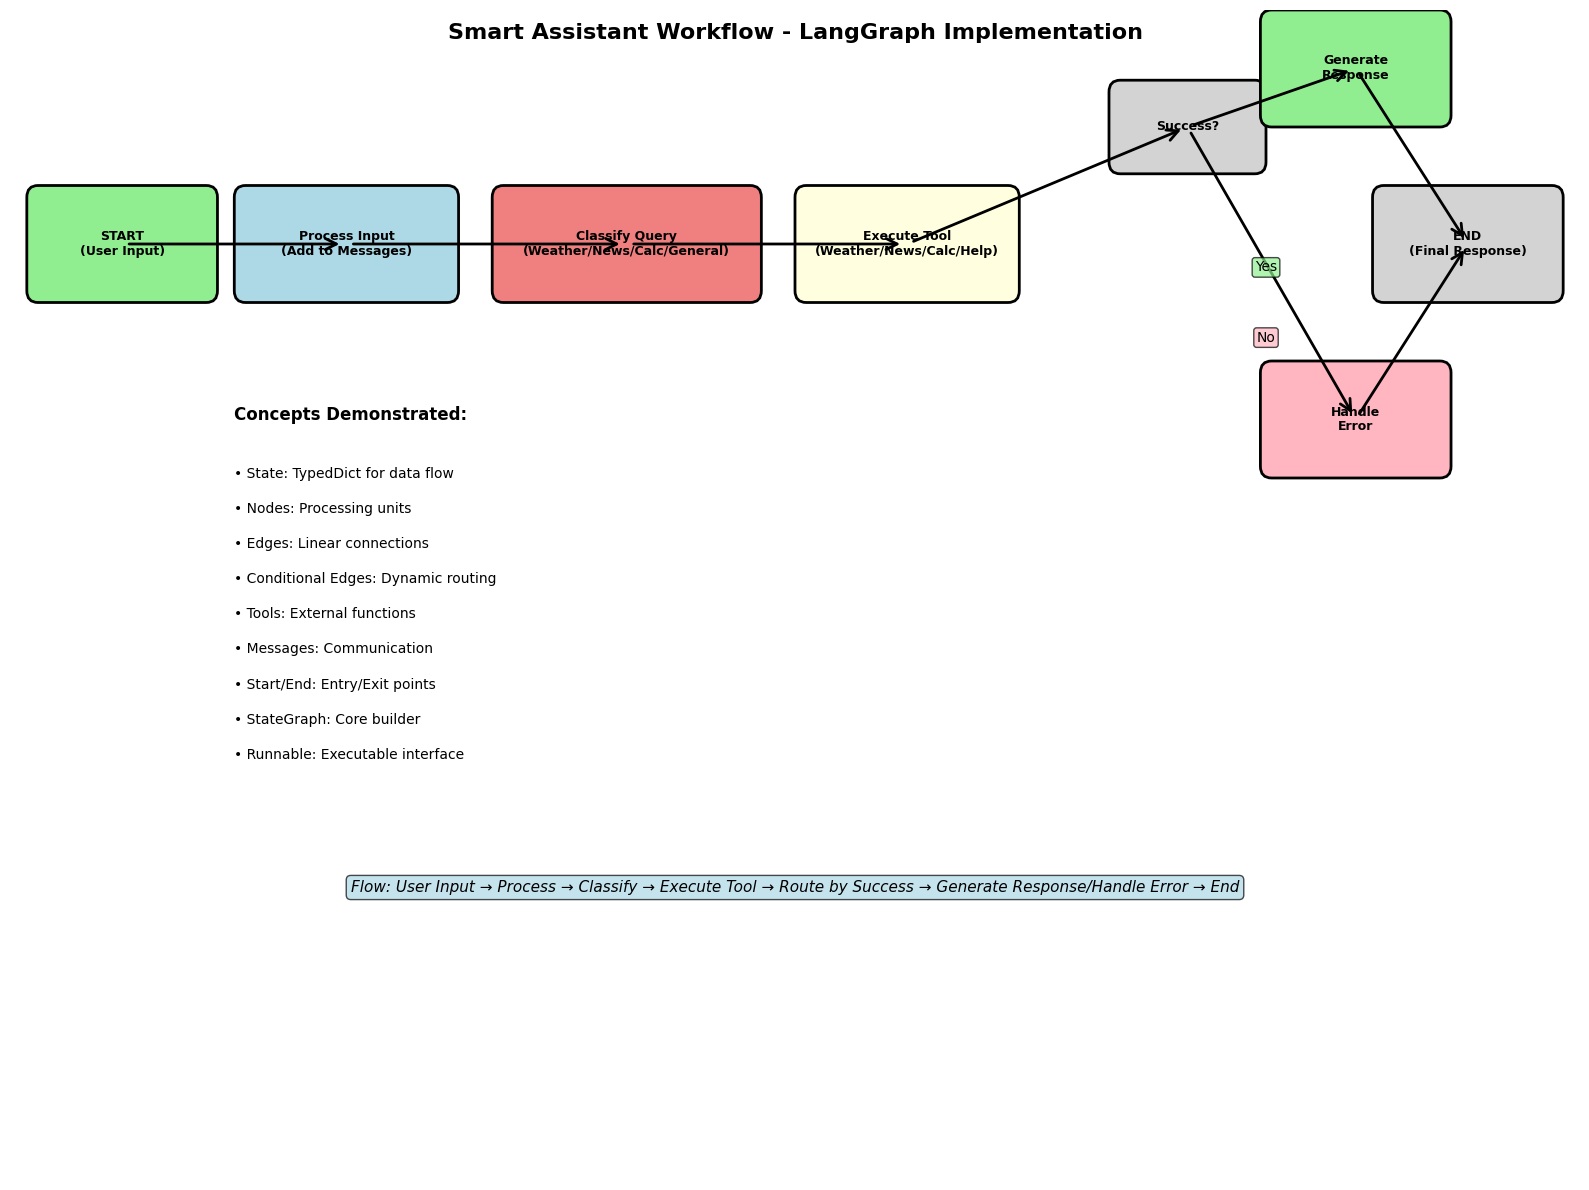

In [15]:
# Visual Workflow Graph
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import numpy as np

def create_workflow_visualization():
    """Create a visual representation of our smart assistant workflow"""
    
    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Define node positions and properties
    nodes = {
        'start': {'pos': (1, 8), 'label': 'START\n(User Input)', 'color': 'lightgreen', 'size': (1.5, 0.8)},
        'process_input': {'pos': (3, 8), 'label': 'Process Input\n(Add to Messages)', 'color': 'lightblue', 'size': (1.8, 0.8)},
        'classify_query': {'pos': (5.5, 8), 'label': 'Classify Query\n(Weather/News/Calc/General)', 'color': 'lightcoral', 'size': (2.2, 0.8)},
        'execute_tool': {'pos': (8, 8), 'label': 'Execute Tool\n(Weather/News/Calc/Help)', 'color': 'lightyellow', 'size': (1.8, 0.8)},
        'success': {'pos': (10.5, 9), 'label': 'Success?', 'color': 'lightgray', 'size': (1.2, 0.6)},
        'generate_response': {'pos': (12, 9.5), 'label': 'Generate\nResponse', 'color': 'lightgreen', 'size': (1.5, 0.8)},
        'handle_error': {'pos': (12, 6.5), 'label': 'Handle\nError', 'color': 'lightpink', 'size': (1.5, 0.8)},
        'end': {'pos': (13, 8), 'label': 'END\n(Final Response)', 'color': 'lightgray', 'size': (1.5, 0.8)}
    }
    
    # Draw nodes
    for node_name, props in nodes.items():
        x, y = props['pos']
        color = props['color']
        label = props['label']
        width, height = props['size']
        
        # Create rounded rectangle for node
        bbox = FancyBboxPatch(
            (x-width/2, y-height/2), width, height,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor='black',
            linewidth=2
        )
        ax.add_patch(bbox)
        
        # Add text
        ax.text(x, y, label, ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Draw edges
    edges = [
        ('start', 'process_input'),
        ('process_input', 'classify_query'),
        ('classify_query', 'execute_tool'),
        ('execute_tool', 'success'),
        ('success', 'generate_response'),
        ('success', 'handle_error'),
        ('generate_response', 'end'),
        ('handle_error', 'end')
    ]
    
    for start_node, end_node in edges:
        start_pos = nodes[start_node]['pos']
        end_pos = nodes[end_node]['pos']
        
        # Create arrow
        arrow = ConnectionPatch(
            start_pos, end_pos, "data", "data",
            arrowstyle="->", shrinkA=5, shrinkB=5,
            mutation_scale=20, fc="black", lw=2
        )
        ax.add_patch(arrow)
    
    # Add conditional routing labels
    ax.text(11.2, 7.8, 'Yes', ha='center', va='center', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.2", facecolor='lightgreen', alpha=0.7))
    ax.text(11.2, 7.2, 'No', ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.2", facecolor='lightpink', alpha=0.7))
    
    # Add title and description
    ax.text(7, 9.8, 'Smart Assistant Workflow - LangGraph Implementation',
            ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Add concept labels
    ax.text(2, 6.5, 'Concepts Demonstrated:', fontsize=12, fontweight='bold')
    ax.text(2, 6, '• State: TypedDict for data flow', fontsize=10)
    ax.text(2, 5.7, '• Nodes: Processing units', fontsize=10)
    ax.text(2, 5.4, '• Edges: Linear connections', fontsize=10)
    ax.text(2, 5.1, '• Conditional Edges: Dynamic routing', fontsize=10)
    ax.text(2, 4.8, '• Tools: External functions', fontsize=10)
    ax.text(2, 4.5, '• Messages: Communication', fontsize=10)
    ax.text(2, 4.2, '• Start/End: Entry/Exit points', fontsize=10)
    ax.text(2, 3.9, '• StateGraph: Core builder', fontsize=10)
    ax.text(2, 3.6, '• Runnable: Executable interface', fontsize=10)
    
    # Add flow description
    ax.text(7, 2.5, 'Flow: User Input → Process → Classify → Execute Tool → Route by Success → Generate Response/Handle Error → End',
            ha='center', va='center', fontsize=11, style='italic',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Create the visualization
print("🎨 Creating Smart Assistant Workflow Visualization...")
create_workflow_visualization()


🔗 Creating Component Relationship Visualization...


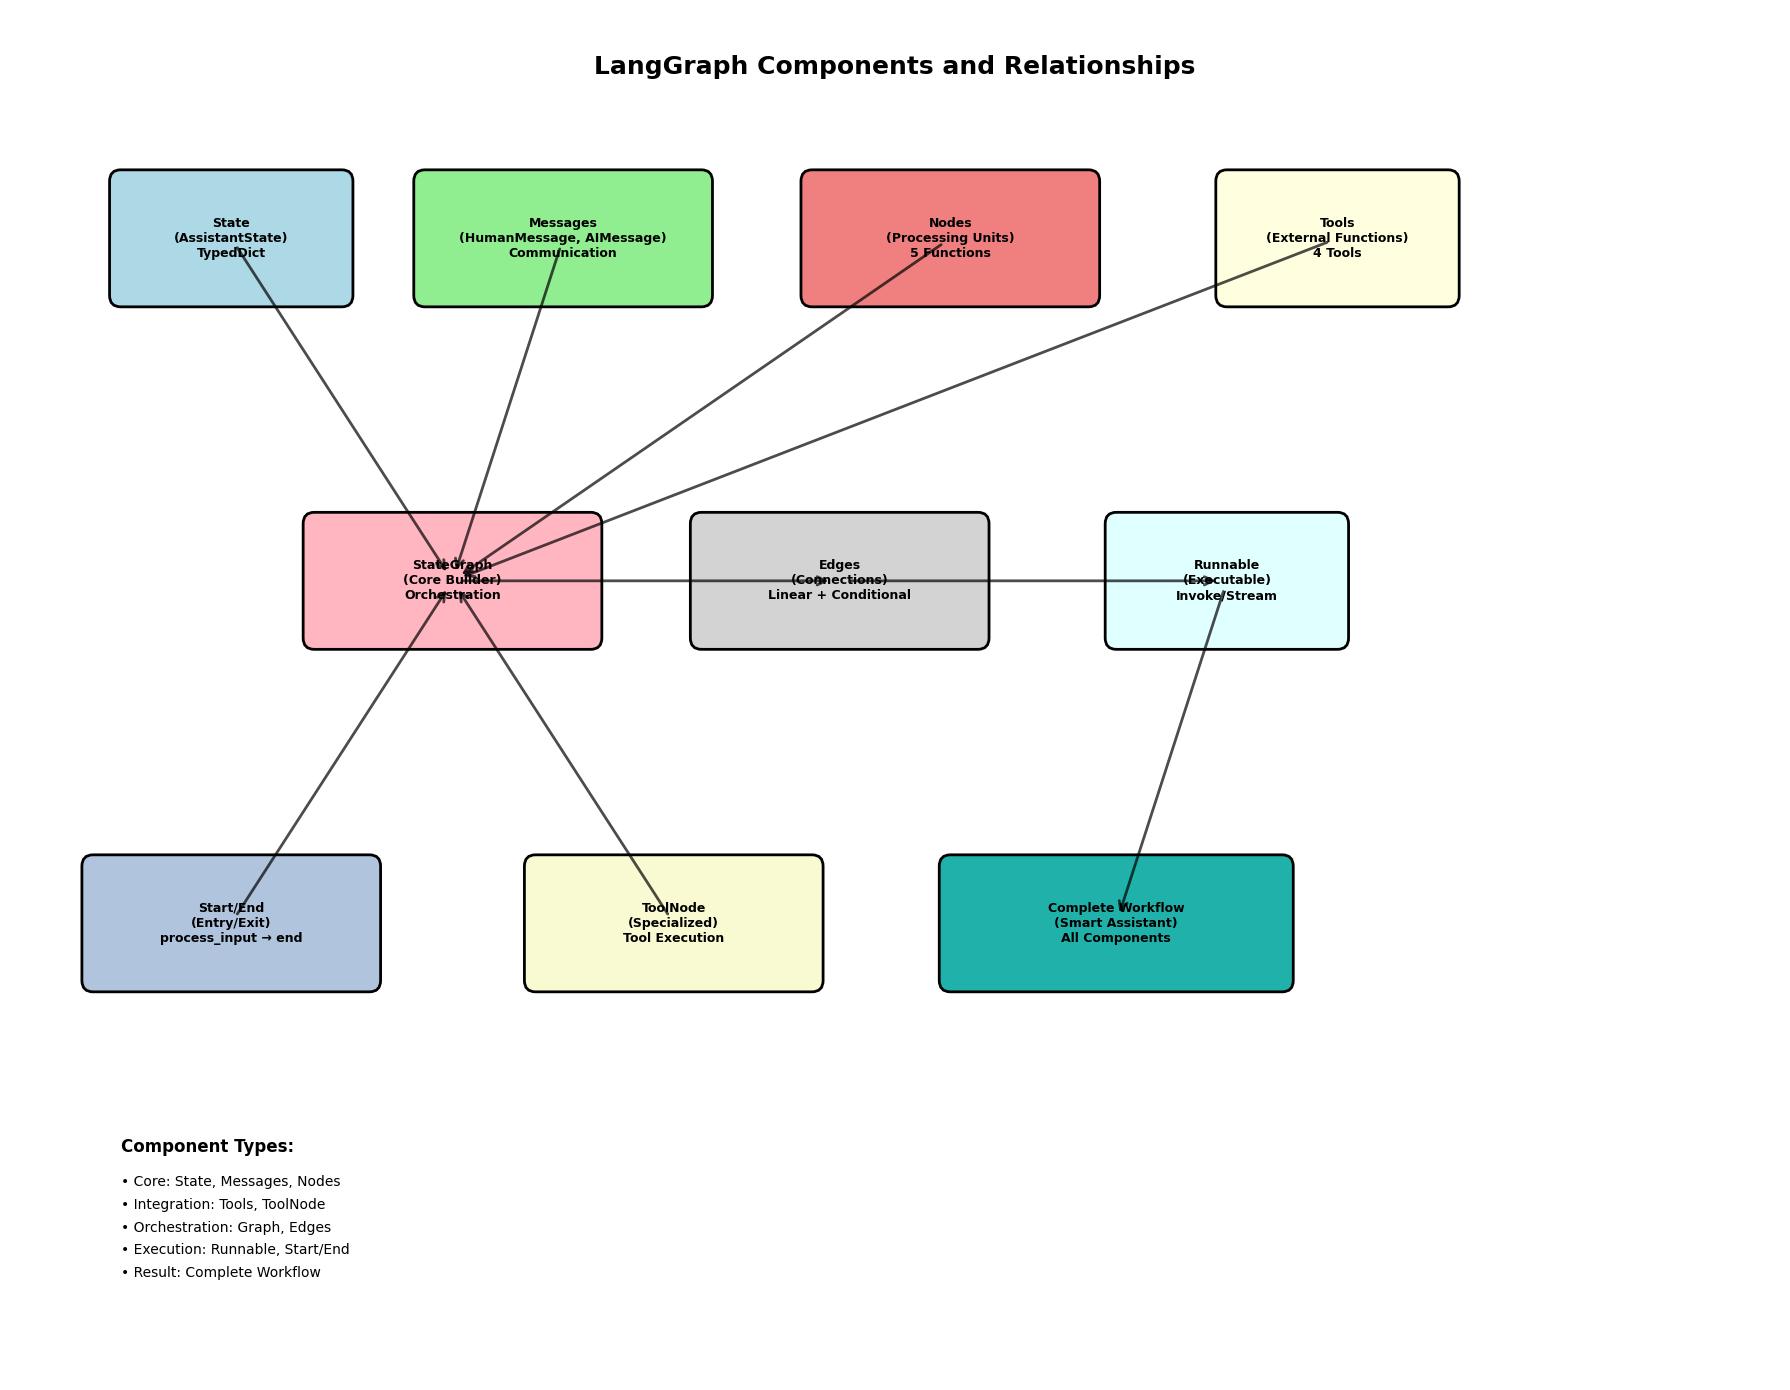

In [16]:
# Detailed Component Relationship Graph
def create_component_relationship_graph():
    """Create a detailed graph showing component relationships"""
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 14))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 12)
    ax.axis('off')
    
    # Define component positions and properties
    components = {
        'state': {'pos': (2, 10), 'label': 'State\n(AssistantState)\nTypedDict', 'color': 'lightblue', 'size': (2, 1)},
        'messages': {'pos': (5, 10), 'label': 'Messages\n(HumanMessage, AIMessage)\nCommunication', 'color': 'lightgreen', 'size': (2.5, 1)},
        'nodes': {'pos': (8.5, 10), 'label': 'Nodes\n(Processing Units)\n5 Functions', 'color': 'lightcoral', 'size': (2.5, 1)},
        'tools': {'pos': (12, 10), 'label': 'Tools\n(External Functions)\n4 Tools', 'color': 'lightyellow', 'size': (2, 1)},
        'graph': {'pos': (4, 7), 'label': 'StateGraph\n(Core Builder)\nOrchestration', 'color': 'lightpink', 'size': (2.5, 1)},
        'edges': {'pos': (7.5, 7), 'label': 'Edges\n(Connections)\nLinear + Conditional', 'color': 'lightgray', 'size': (2.5, 1)},
        'runnable': {'pos': (11, 7), 'label': 'Runnable\n(Executable)\nInvoke/Stream', 'color': 'lightcyan', 'size': (2, 1)},
        'start_end': {'pos': (2, 4), 'label': 'Start/End\n(Entry/Exit)\nprocess_input → end', 'color': 'lightsteelblue', 'size': (2.5, 1)},
        'toolnode': {'pos': (6, 4), 'label': 'ToolNode\n(Specialized)\nTool Execution', 'color': 'lightgoldenrodyellow', 'size': (2.5, 1)},
        'workflow': {'pos': (10, 4), 'label': 'Complete Workflow\n(Smart Assistant)\nAll Components', 'color': 'lightseagreen', 'size': (3, 1)}
    }
    
    # Draw components
    for comp_name, props in components.items():
        x, y = props['pos']
        color = props['color']
        label = props['label']
        width, height = props['size']
        
        bbox = FancyBboxPatch(
            (x-width/2, y-height/2), width, height,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor='black',
            linewidth=2
        )
        ax.add_patch(bbox)
        
        ax.text(x, y, label, ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Draw relationships
    relationships = [
        ('state', 'graph'),
        ('messages', 'graph'),
        ('nodes', 'graph'),
        ('tools', 'graph'),
        ('graph', 'edges'),
        ('edges', 'runnable'),
        ('start_end', 'graph'),
        ('toolnode', 'graph'),
        ('runnable', 'workflow')
    ]
    
    for start_comp, end_comp in relationships:
        start_pos = components[start_comp]['pos']
        end_pos = components[end_comp]['pos']
        
        arrow = ConnectionPatch(
            start_pos, end_pos, "data", "data",
            arrowstyle="->", shrinkA=8, shrinkB=8,
            mutation_scale=15, fc="darkblue", lw=2, alpha=0.7
        )
        ax.add_patch(arrow)
    
    # Add title
    ax.text(8, 11.5, 'LangGraph Components and Relationships',
            ha='center', va='center', fontsize=18, fontweight='bold')
    
    # Add legend
    ax.text(1, 2, 'Component Types:', fontsize=12, fontweight='bold')
    ax.text(1, 1.7, '• Core: State, Messages, Nodes', fontsize=10)
    ax.text(1, 1.5, '• Integration: Tools, ToolNode', fontsize=10)
    ax.text(1, 1.3, '• Orchestration: Graph, Edges', fontsize=10)
    ax.text(1, 1.1, '• Execution: Runnable, Start/End', fontsize=10)
    ax.text(1, 0.9, '• Result: Complete Workflow', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Create the component relationship visualization
print("🔗 Creating Component Relationship Visualization...")
create_component_relationship_graph()


📊 Creating Data Flow and State Management Visualization...


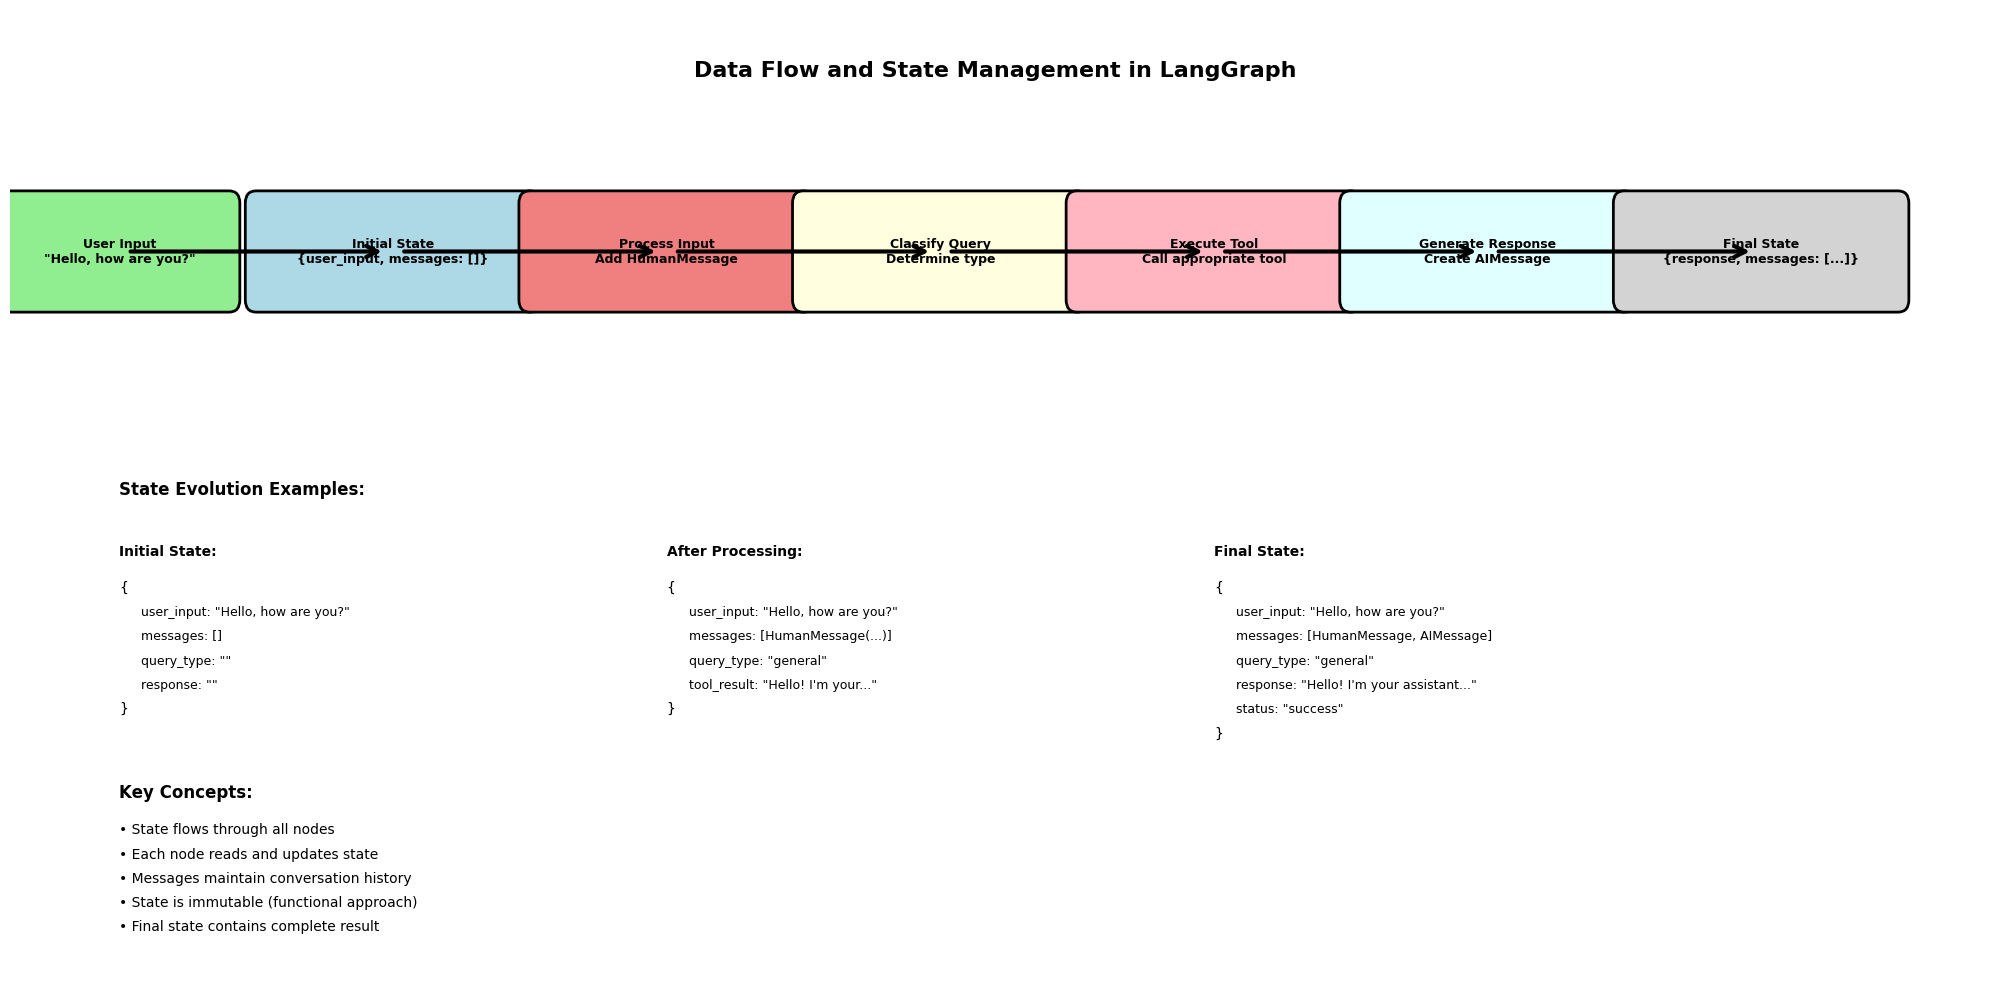

In [17]:
# Data Flow and State Management Visualization
def create_data_flow_visualization():
    """Create a visualization showing data flow and state management"""
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_xlim(0, 18)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Define data flow positions
    flow_components = {
        'user_input': {'pos': (1, 6), 'label': 'User Input\n"Hello, how are you?"', 'color': 'lightgreen', 'size': (2, 0.8)},
        'state_init': {'pos': (3.5, 6), 'label': 'Initial State\n{user_input, messages: []}', 'color': 'lightblue', 'size': (2.5, 0.8)},
        'process_node': {'pos': (6, 6), 'label': 'Process Input\nAdd HumanMessage', 'color': 'lightcoral', 'size': (2.5, 0.8)},
        'classify_node': {'pos': (8.5, 6), 'label': 'Classify Query\nDetermine type', 'color': 'lightyellow', 'size': (2.5, 0.8)},
        'tool_node': {'pos': (11, 6), 'label': 'Execute Tool\nCall appropriate tool', 'color': 'lightpink', 'size': (2.5, 0.8)},
        'response_node': {'pos': (13.5, 6), 'label': 'Generate Response\nCreate AIMessage', 'color': 'lightcyan', 'size': (2.5, 0.8)},
        'final_state': {'pos': (16, 6), 'label': 'Final State\n{response, messages: [...]}', 'color': 'lightgray', 'size': (2.5, 0.8)}
    }
    
    # Draw flow components
    for comp_name, props in flow_components.items():
        x, y = props['pos']
        color = props['color']
        label = props['label']
        width, height = props['size']
        
        bbox = FancyBboxPatch(
            (x-width/2, y-height/2), width, height,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor='black',
            linewidth=2
        )
        ax.add_patch(bbox)
        
        ax.text(x, y, label, ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Draw flow arrows
    flow_edges = [
        ('user_input', 'state_init'),
        ('state_init', 'process_node'),
        ('process_node', 'classify_node'),
        ('classify_node', 'tool_node'),
        ('tool_node', 'response_node'),
        ('response_node', 'final_state')
    ]
    
    for start_comp, end_comp in flow_edges:
        start_pos = flow_components[start_comp]['pos']
        end_pos = flow_components[end_comp]['pos']
        
        arrow = ConnectionPatch(
            start_pos, end_pos, "data", "data",
            arrowstyle="->", shrinkA=8, shrinkB=8,
            mutation_scale=20, fc="darkred", lw=3
        )
        ax.add_patch(arrow)
    
    # Add state evolution examples
    ax.text(1, 4, 'State Evolution Examples:', fontsize=12, fontweight='bold')
    
    # Initial state
    ax.text(1, 3.5, 'Initial State:', fontsize=10, fontweight='bold')
    ax.text(1, 3.2, '{', fontsize=10)
    ax.text(1.2, 3, 'user_input: "Hello, how are you?"', fontsize=9)
    ax.text(1.2, 2.8, 'messages: []', fontsize=9)
    ax.text(1.2, 2.6, 'query_type: ""', fontsize=9)
    ax.text(1.2, 2.4, 'response: ""', fontsize=9)
    ax.text(1, 2.2, '}', fontsize=10)
    
    # After processing
    ax.text(6, 3.5, 'After Processing:', fontsize=10, fontweight='bold')
    ax.text(6, 3.2, '{', fontsize=10)
    ax.text(6.2, 3, 'user_input: "Hello, how are you?"', fontsize=9)
    ax.text(6.2, 2.8, 'messages: [HumanMessage(...)]', fontsize=9)
    ax.text(6.2, 2.6, 'query_type: "general"', fontsize=9)
    ax.text(6.2, 2.4, 'tool_result: "Hello! I\'m your..."', fontsize=9)
    ax.text(6, 2.2, '}', fontsize=10)
    
    # Final state
    ax.text(11, 3.5, 'Final State:', fontsize=10, fontweight='bold')
    ax.text(11, 3.2, '{', fontsize=10)
    ax.text(11.2, 3, 'user_input: "Hello, how are you?"', fontsize=9)
    ax.text(11.2, 2.8, 'messages: [HumanMessage, AIMessage]', fontsize=9)
    ax.text(11.2, 2.6, 'query_type: "general"', fontsize=9)
    ax.text(11.2, 2.4, 'response: "Hello! I\'m your assistant..."', fontsize=9)
    ax.text(11.2, 2.2, 'status: "success"', fontsize=9)
    ax.text(11, 2, '}', fontsize=10)
    
    # Add title
    ax.text(9, 7.5, 'Data Flow and State Management in LangGraph',
            ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Add concept explanations
    ax.text(1, 1.5, 'Key Concepts:', fontsize=12, fontweight='bold')
    ax.text(1, 1.2, '• State flows through all nodes', fontsize=10)
    ax.text(1, 1, '• Each node reads and updates state', fontsize=10)
    ax.text(1, 0.8, '• Messages maintain conversation history', fontsize=10)
    ax.text(1, 0.6, '• State is immutable (functional approach)', fontsize=10)
    ax.text(1, 0.4, '• Final state contains complete result', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Create the data flow visualization
print("📊 Creating Data Flow and State Management Visualization...")
create_data_flow_visualization()
